In [1]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from pathlib import Path
import re

In [2]:
column_mapping = {
    'freq[Hz]': 'freq',
    'Magnitude_S11[dB]': 'magnitude',
    'Phase_S11[°]': 'phase',
    'mag:Smith_S11[U]': 'smith_mag',
    'ang:Smith_S11[°]': 'smith_ang'
}

def phase_fix(phase):
    phase_diff = np.pad(phase[1:] - phase[:-1], pad_width=(1,0))
    phase_jump = np.cumsum(phase_diff > 300)  
    phase_fix = phase - 360 * phase_jump
    #plt.plot(phase_fix)
    return phase_fix


def make_dataset(f):
    """
    1. add medium label and run number according to the file name
    2. rename columns using the global `column_mapping`, remove other columns
    3. detect and correct phase 2pi jumps
    4. fit and subtract linear phase bias due to cable
    5. scale freq to MHz
    """
    res = re.match("[^/]*/(voda|vzduch)_([0-9]).csv", str(f))
    medium, i_run = res.groups()
    df = pd.read_csv(f, sep=';', comment='#', encoding='latin-1')

    # Rename columns based on the mapping
    unknown_cols = [c for c in df.columns if c not in column_mapping]
    df.drop(columns=unknown_cols, inplace=True)
    df.rename(columns=column_mapping, inplace=True)
    
    df['phase_fix'] = phase_fix(np.array(df.phase)) 
    speed, shift = np.polyfit(df.freq, df.phase_fix, deg=1)
    print(f"{medium}, #{i_run}: cable_phase = {shift} + {speed} * freq")
    df['phase_cal_shift'] = shift
    df['phase_cal_speed'] = speed
    df['medium'] = medium
    df['run'] = i_run
    phase_calibrated = df.phase_fix - shift - speed * df.freq
    #plt.plot(phase_calibrated)
    df['phase_calibrated'] = phase_calibrated
    df.freq /=1e6
    return df
           
measurement_dir=Path("./2023_06_16")
datasets = [
    make_dataset(f)
    for f in measurement_dir.glob("*_[0-9].csv")
]
df = pd.concat(datasets, ignore_index=True)

#print(df)

voda, #2: cable_phase = 400.65988688752424 + -6.968917497768262e-06 * freq
voda, #0: cable_phase = 764.8045520882481 + -6.987050912395859e-06 * freq
voda, #1: cable_phase = 387.4426461582714 + -6.832270969640303e-06 * freq
vzduch, #2: cable_phase = 357.44641046186706 + -6.289122854939187e-06 * freq
vzduch, #1: cable_phase = 362.12890258287257 + -6.328959991426229e-06 * freq
vzduch, #0: cable_phase = 358.1849702769717 + -6.2918741971923165e-06 * freq


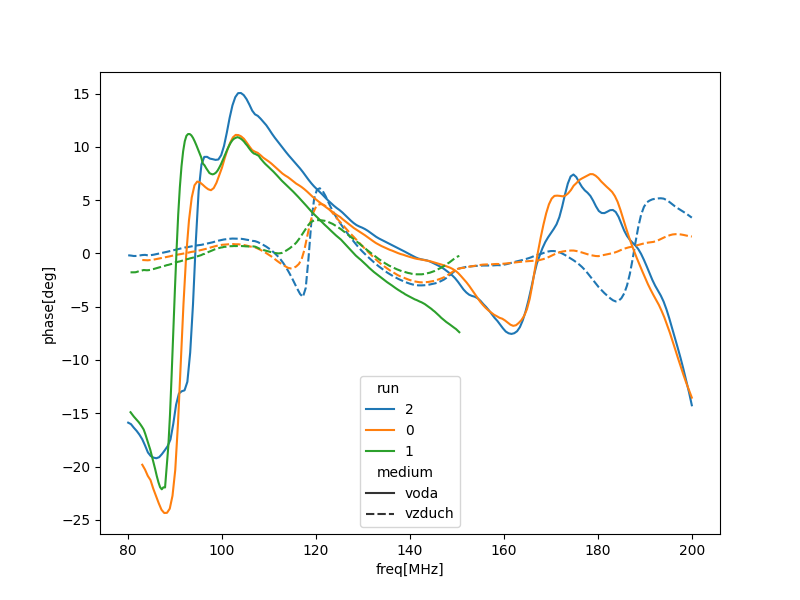

In [3]:
"""
Plot phase runs.
"""
plt.figure(figsize=(8, 6))
sns.lineplot(data=df, x='freq', y='phase_calibrated', hue='run', style='medium')

# Add labels and title
plt.xlabel('freq[MHz]')
plt.ylabel('phase[deg]')
plt.show()


Text(0, 0.5, 'magnitude[$\\Omega$]')

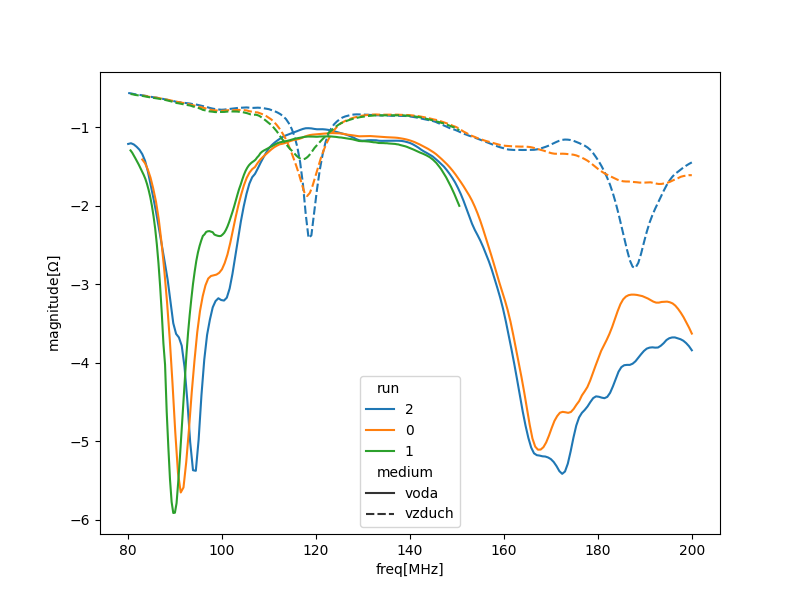

In [4]:
"""
Plot impedance / magnitude.
"""
plt.figure(figsize=(8, 6))
sns.lineplot(data=df, x='freq', y='magnitude', hue='run', style='medium')

# Add labels and title
plt.xlabel('freq[MHz]')
plt.ylabel('magnitude[$\Omega$]')

The difference is clearly above the noise which possibly is due to change in the spatial setup of the measurement. We notice a big sensitivity of the measurement to:

1. particular position and bending of the coaxial cable
2. our presence in about 1m perimeter

The sensitivity seems to be good in the three intervals: $80$ - $90$, $90$ - $120$m, and $150$-$170$ MHz. To better visualize the sensitivity, we shall display ratio:

$$
\frac{|\phi_w(f) - \phi_a(f)|}{\sqrt{\frac12 (\sigma_w^2 + \sigma_a^2)}}
$$
where $\phi_w$, $\phi_a$ are the phase measurements for the water and the air respectively, and $\sigma$ denotes standard deviation from three runs.

In [5]:
"""
Resample runs to the common grid.
Group by the frequency and medium.
"""
from scipy.interpolate import interp1d

n_samples = 50
freq_common = np.linspace(85, 150, n_samples)

def resample_quantity(group, q_name):
    interp_func = interp1d(group['freq'], group[q_name], kind='linear')
    return interp_func(freq_common)

def resample_group(group):
    phase = resample_quantity(group, 'phase_calibrated')
    mag = resample_quantity(group, 'magnitude')
    resampled_df = pd.DataFrame({'freq': freq_common,
                                 'phase': phase,
                                 'mag': mag,
                                 'medium': group['medium'].unique()[0],
                                 'run': group['run'].unique()[0]})
    return resampled_df


groups = df.groupby(['medium', 'run'])    
groups_df = [resample_group(group) for _, group in groups]
resampled_df = pd.concat(groups_df, ignore_index=True)    
print(resampled_df)

           freq      phase       mag  medium run
0     85.000000 -21.613453 -1.701099    voda   0
1     86.326531 -23.233291 -2.103808    voda   0
2     87.653061 -24.349241 -2.799965    voda   0
3     88.979592 -23.689295 -3.823483    voda   0
4     90.306122 -18.183710 -5.136304    voda   0
..          ...        ...       ...     ...  ..
295  144.693878  -2.869002 -0.918269  vzduch   2
296  146.020408  -2.718669 -0.947095  vzduch   2
297  147.346939  -2.415046 -0.981345  vzduch   2
298  148.673469  -1.963005 -1.015423  vzduch   2
299  150.000000  -1.510853 -1.043386  vzduch   2

[300 rows x 5 columns]


c std
 [1.17306099 1.51219943 2.10798578 3.40223822 6.8999215  8.06028771
 7.73598199 3.73725322 0.93949881 1.09628046 0.96804457 0.58651403
 0.72658576 1.33601777 1.68254879 1.73054993 1.59784571 1.48601974
 1.47511804 1.35889099 1.26074936 1.24526621 1.35696706 1.69607206
 2.21961595 1.79554782 1.10882781 1.41360545 1.22996349 1.06341047
 1.01584953 1.02505898 1.06641737 1.13695252 1.22175373 1.29668517
 1.33205709 1.38515471 1.446984   1.51038956 1.55931556 1.60132923
 1.63151891 1.6689205  1.75023786 1.8614985  1.98073513 2.09371653
 2.13737374 2.12921147]
c std
 [0.10170438 0.2033289  0.46562163 0.85746581 0.77755425 0.60940394
 0.54609952 0.91894464 0.70070819 0.45091366 0.3196914  0.28646504
 0.31374173 0.28198862 0.20190618 0.1302288  0.07915429 0.06371184
 0.05764047 0.06837999 0.08870637 0.11542767 0.12742796 0.1169101
 0.11239276 0.32526903 0.30581456 0.13080854 0.05025746 0.03704102
 0.03426791 0.03186314 0.02775876 0.02656787 0.02650897 0.02676577
 0.02764819 0.0281814  0.

/tmp/ipykernel_12827/1340835922.py:11: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  water_stat, air_stat = [g for m, g in df.groupby(['medium'])]


Text(0, 0.5, 'sensitivity: ($\\overline{q}_w - \\overline{q}_a) / \\sigma$')

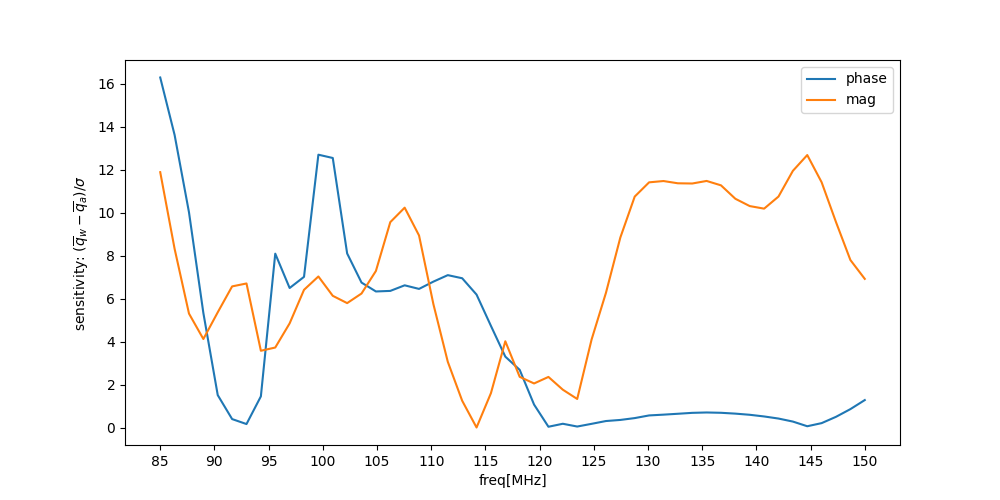

In [8]:
"""
Now calculate statistics over runs.
"""
ops = ['mean', 'std']
run_stats = resampled_df.groupby(['freq', 'medium']).agg({'phase': ops, 'mag': ops})
#print(run_stats)
#water_stat, air_stat = [g for m, g in run_stats.groupby(['medium'])]


def sensitivity(df, q_name):
    water_stat, air_stat = [g for m, g in df.groupby(['medium'])]
    #print(air_stat)
    q_water = water_stat[q_name]
    q_air = air_stat[q_name]
    mean_w, mean_a = [np.array(q['mean']) for q in [q_water, q_air]]
    diff = mean_w - mean_a

    std_w, std_a = [np.array(q['std']) for q in [q_water, q_air]]
    common_std = np.sqrt(0.5 * (std_w**2 + std_a**2))
    
    print("c std\n", common_std)
    
    return np.abs(diff) / common_std

phase_sens = sensitivity(run_stats, 'phase')
mag_sens = sensitivity(run_stats, 'mag')

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(freq_common, phase_sens, label='phase')
ax.plot(freq_common, mag_sens, label='mag')
ax.legend()
ax.set_xticks(np.arange(min(freq_common), max(freq_common)+1, 5.0))
ax.set_xlabel('freq[MHz]')
ax.set_ylabel('sensitivity: ($\overline{q}_w - \overline{q}_a) / \sigma$')

For the phase, we can use frequencies from the interval $95$-$115$ in particular the freqency $100$ has high sensitivity. For the magnitude the interval $98$-$110$ has similar sensitivity to the phase and there seems to be high sensitivity in the interval $130$-$150$.